<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/Week_5/Week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from IPython.display import YouTubeVideo

# ML import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import MinMaxScaler       # Normalization
from sklearn.preprocessing import LabelEncoder       # Encoder
import torch                                   # PyTorch
import torch.nn as nn                          # PyTorch building blocks
from IPython.display import YouTubeVideo

# Neural Nets Examples

### Application: Predicting house prices

In this application, we will implement a Shallow Neural Network model with PyTorch to predict house prices using the [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

#### Data

In [ ]:
# import data
raw_data = pd.read_csv("https://raw.githubusercontent.com/JasminaZHAW/MLDM2/main/labs/data/house_price.csv")
raw_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
raw_data.shape

(1460, 81)

The dataset contains 81 columns. A description of the features is available in the file "[house_price_data_description](https://github.com/michalis0/DataScience_and_MachineLearning/blob/master/Week_5/data/house_price_data_description.txt)"

##### Preprocessing

Let's first extract the features of interest. We will use the numeric columns:

In [ ]:
# Data types
raw_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [ ]:
# Display numeric features (integer and floats)
numeric_columns = list(raw_data.columns[(raw_data.dtypes==np.int64) |
                 (raw_data.dtypes==np.float64)])
print(numeric_columns, "\n", len(numeric_columns))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 
 38


`SalePrice` is the value we want to predict. We set it as the last column:

In [ ]:
# Output SalePrice as last column
numeric_columns.remove('SalePrice')
numeric_columns.append('SalePrice')

We also remove the `Id` column:

In [ ]:
# Remove Id
numeric_columns.remove('Id')

Now we extract the numeric data.

In [ ]:
# Extract numeric data
numeric_data = raw_data[numeric_columns]
numeric_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let's deal with the missing values in the data.

In [ ]:
# Display features with missing values
nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
nan_columns

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

We simply replace them with zero.

In [ ]:
# Replace NAN with 0
numeric_data = numeric_data.fillna(0)

##### Creating training and test set

Let's split the data for training and test. We use the `train_test_split` module of `sklearn`:

In [ ]:
# Splitting training/test set
numeric_data_train, numeric_data_test = train_test_split(numeric_data, test_size=0.1, random_state=7)

##### Normalizing the data

Before training our model, we need to normalize the data. We do this by subtracting each column from its minimum value and then dividing it by the difference between maximum and minimum. We use the `MinMaxScaler` of `sklearn`.

In [ ]:
#Define the scaler
scaler = MinMaxScaler()
#Fit the scaler
scaler.fit(numeric_data_train)
#Transform the train and the test set
numeric_data_train.loc[:,:] = scaler.transform(numeric_data_train)
numeric_data_test.loc[:,:] = scaler.transform(numeric_data_test)

Finally, we split the column we want to predict ("SalePrice") to our features:

In [ ]:
# Extract features and output
numeric_x_columns = list(numeric_data_train.columns)
numeric_x_columns.remove("SalePrice")
X_train_df = numeric_data_train[numeric_x_columns]
y_train_df = pd.DataFrame(numeric_data_train["SalePrice"])
X_test_df = numeric_data_test[numeric_x_columns]
y_test_df = pd.DataFrame(numeric_data_test["SalePrice"])

Ok, all set, we can start building our Neural Net!

#### Building a Shallow Neural Network model with PyTorch

We use the `PyTorch` library ([Documentation](https://pytorch.org/), imported at the beginning of this notebook with the following lines of codes:

```python
import torch
import torch.nn as nn
```

`torch.nn` contains the building blocks to build Neural Nets, e.g., the layers ([Documentation](https://pytorch.org/docs/stable/nn.html)).

##### Create tensors

The first step is to convert the data into torch tensors. A `torch.Tensor` is a multi-dimensional matrix containing elements of a single data type. It's very similar to arrays in `NumPy`.

We rely on `torch.tensor()` for the conversion ([Documentation](https://pytorch.org/docs/stable/tensors.html)).

In [ ]:
X_train = torch.tensor(X_train_df.values, dtype=torch.float)
y_train = torch.tensor(y_train_df.values, dtype=torch.float)
X_test = torch.tensor(X_test_df.values, dtype=torch.float)
y_test = torch.tensor(y_test_df.values, dtype=torch.float)

In [ ]:
print(X_train.size(), y_train.size())

torch.Size([1314, 36]) torch.Size([1314, 1])


##### Define and train a model with PyTorch

A model is defined as a `class` in PyTorch. Classes are a means of bundling data and functionality together, allowing to create a new type of Python object. You can read the Python documentation on [Classes](https://docs.python.org/3/tutorial/classes.html) to learn more about them.

When you create your Neural Net, you should define:
- a `__init__` function in which you define the layers of your network.
- a `forward` function (method) that defines the forward pass on the network.

Now the goal is to create a single layer network with ReLU activation:
- The layer `nn.Linear()` performs a linear transformation ([Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)). The input and output are the number of neurons
- `nn.ReLU()` applies the Rectified Linear Unit function: $ReLU(x)=\max(0,x)$ ([Documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

In [ ]:
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)        # Linear transformation for hidden layer
        self.linear2 = nn.Linear(H1, D_out)       # Linear transformation for output layer
        self.activation = nn.ReLU()               # Activation function for hidden layer

    def forward(self, x):
        y_pred = self.activation(self.linear1(x))   # Hidden layer: linear transformation + ReLU
        y_pred = self.linear2(y_pred)               # Output layer: linear transformation
        return y_pred

`D_in` is the input dimension, i.e., the number of features. Similarly, `D_out` is the output dimension, i.e., 1 (we only predict the "SalePrice"):

In [ ]:
D_in, D_out = X_train.shape[1], y_train.shape[1]

Ok, let's define our first model. It is an instance of our newly-created class "Net". We are going to use 500 neurons for the hidden layer:

In [ ]:
# Model with 500 neurons
model1 = Net(D_in, 500, D_out)

Let's calculate now how many parameters we have in the model.

In [ ]:
# calculate how many parameters are in the model
pytorch_total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(pytorch_total_params)

19001


The next steps is to define the **loss criterion** and the **optimizer** for the network. That is, we have to define the loss function we want to optimize during training and also the optimization method. We use:
- `MSELoss()` as loss criterion, i.e., the mean square error ([Documentation](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html))
- `SGD()`as optimizer, i.e., stochastic gradient descent ([Documentation](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html))

In [ ]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-4)

Wonderful, we are ready to do the training! We can simply by looping over the number of iterations. The training has 3 main steps:
- A forward pass to compute the prediction for the current data point (batch).
- Computing the loss for the current prediction with the previously defined criterion.
- A backward pass to compute the gradient of the loss with respect to the weight of the network (`backward()`)
- Finally, updating the weights of the network (`optimizer.step()`).

Note that in each backward pass PyTorch saves the gradient for all of the parameters. Therefore it is important to replace the old gradient values with zero in the beginning of each iteration (`optimizer.zero_grad()`), otherwise the gradients will be accumulated during the iterations!

In [ ]:
losses1 = []
losses1_test = []

for t in range(500):                # 500 iterations

    # Forward pass: compute prediction on training set
    y_pred = model1(X_train)

    # Compute loss
    loss = criterion(y_pred, y_train)
    print(t, loss.item())
    losses1.append(loss.item())
    if torch.isnan(loss):
        break

    # Compute gradient
    optimizer.zero_grad()
    loss.backward()

    # Update
    optimizer.step()

    # Compute loss on test set
    losses1_test.append(criterion(model1(X_test), y_test).item())

0 156.39678955078125
1 967.2960205078125
2 5312.82373046875
3 7639.046875
4 283.7851257324219
5 149.80709838867188
6 83.18368530273438
7 49.61655807495117
8 32.58191680908203
9 23.87906265258789
10 19.390562057495117
11 17.0369930267334
12 15.766419410705566
13 15.045997619628906
14 14.605480194091797
15 14.30778694152832
16 14.083463668823242
17 13.897359848022461
18 13.731629371643066
19 13.577133178710938
20 13.429250717163086
21 13.28559684753418
22 13.1448974609375
23 13.00654411315918
24 12.870192527770996
25 12.735626220703125
26 12.602727890014648
27 12.47140884399414
28 12.341499328613281
29 12.213062286376953
30 12.086006164550781
31 11.96035385131836
32 11.836103439331055
33 11.71324348449707
34 11.591706275939941
35 11.471450805664062
36 11.35236930847168
37 11.234479904174805
38 11.11778736114502
39 11.002229690551758
40 10.887868881225586
41 10.774656295776367
42 10.662574768066406
43 10.551652908325195
44 10.441871643066406
45 10.333244323730469
46 10.225703239440918
47 

Let's visualize the evolution of the MSE on the training set and test set:

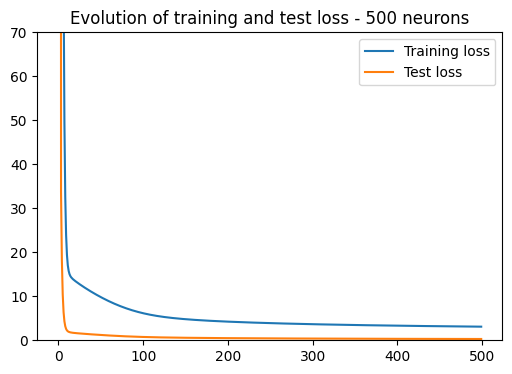

In [ ]:
# Plot training and test loss
plt.figure(figsize=(6, 4))
plt.plot(losses1, label="Training loss")
plt.plot(losses1_test, label="Test loss")
plt.title('Evolution of training and test loss - 500 neurons')
plt.ylim(top=70, bottom=0.0)
plt.legend()
plt.show()

Now let's try a new model with more neurons in the hidden layer. We use 1000 neurons, and follow the same steps as before:

In [ ]:
model2 = Net(D_in, 1000, D_out)

In [ ]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4)

In [ ]:
losses2 = []

for t in range(500):
    y_pred = model2(X_train)

    loss = criterion(y_pred, y_train)
    losses2.append(loss.item())

    if torch.isnan(loss):
        break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Let's visualize the evolution of the training loss for the two models:

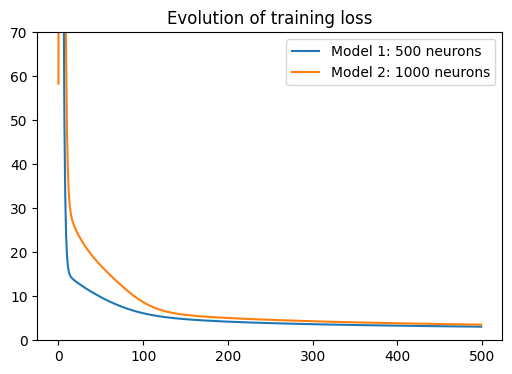

In [ ]:
# Plot training and test loss
plt.figure(figsize=(6, 4))
plt.plot(losses1, label="Model 1: 500 neurons")
plt.plot(losses2, label="Model 2: 1000 neurons")
plt.title('Evolution of training loss')
plt.ylim(top=70, bottom=0.0)
plt.legend()
plt.show()

Let's compare the MSE loss on the test data:

In [ ]:
# prediction for model 1
model1_pred = model1(X_test)
print("MSE loss for model 1: ", criterion(model1_pred, y_test))
# prediction for model 2
model2_pred = model2(X_test)
print("MSE loss for model 2: ", criterion(model2_pred, y_test))

MSE loss for model 1:  tensor(0.2938, grad_fn=<MseLossBackward0>)
MSE loss for model 2:  tensor(0.3284, grad_fn=<MseLossBackward0>)


## Assignment: Predict the streams of a song with a 2 layer neural network

Based on this dataset ([link](https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_5/data/spotify.csv)) imported from kaggle, create a Neural Network that will predict the streams of a song based on its bpm, key, danceability, valence, energy, acousticness, instrumentalness, liveness, and speechiness. (Hint: if there are some errors, try to copy/paste them in Google to see some solutions.)

In [ ]:
# import the dataset
df_lab = pd.read_csv("https://raw.githubusercontent.com/JasminaZHAW/MLDM2/main/labs/data/spotify.csv", encoding='latin-1', index_col="Unnamed: 0")
display(df_lab)

In [ ]:
# select only the columns that you need based on the problem specification and store them in a dataframe


In [ ]:
# split the training/test dataset


In [ ]:
# # encode 'key' feature that is non-numeric to numeric using LabelEncoder


In [ ]:
# scale your data using MinMaxScaler


In [ ]:
# extract features and output


In [ ]:
# Transform the data into tensor


Now create a Neural Net class with two hidden layer using the ReLU activation in both of them:

In [ ]:
class Net_lab(nn.Module):


In [ ]:
# give the right dimension to the input and output layers


In [ ]:
# Create a model with 100 neurons for both hidden layers


In [ ]:
# calculate how many parameters the model has


In [ ]:
# use the MSELoss() as the loss criterion and Adam() as the optimizer (search online the optimizer)


Now create a loop to train your model (with 500 iterations), don't forget to save your loss criterion in order to plot it later !

In [ ]:
# Plot training and test loss
